In [ ]:
#| default_exp analysis

In [ ]:
#| export
from dgrec.utils import parse_genotypes, str_to_mut
import os
import numpy as np
from Bio import SeqIO
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from typing import Dict, Any, List, Callable
import numpy as np
from scipy.stats import linregress
from scipy.integrate import quad

import matplotlib.pyplot as plt

/home/dbikard/anaconda3/envs/dgrec/lib/python3.11/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [ ]:
from dgrec.example_data import get_example_data_dir

In [ ]:
#| export
bases=list("ATGC")
def mut_rate(gen_list:list, #a genotype list with the number of molecules detected
             ran:tuple, #the position range in which to compute the mutation rate. If None the rate is computed for the full sequence.
             ref_seq:str, #reference sequence
             ):
    """Computes the mutation rate per base within the specified range. The rate can be computed for specific bases using the base_restriction argument."""
    mut_pileup=np.zeros(len(ref_seq))
    nTOT = 0
    for g, n in gen_list:
        nTOT += n
        gens = str_to_mut(g)
        for m in gens:
            mut_pileup[m[1]]+=n

    mut_pileup=mut_pileup/nTOT

    mut_n_per_base={}
    for b in bases:
        b_pos= np.where((np.array(list(ref_seq))==b) & 
                (np.arange(len(ref_seq))>ran[0]) & 
                (np.arange(len(ref_seq))<ran[1]))
        mut_n_per_base[b]=mut_pileup[b_pos].mean()

    mut_n_per_base["all"]=mut_pileup[ran[0]:ran[1]].mean()

    return mut_n_per_base
        

In [ ]:
data_path=get_example_data_dir()
gen_list=parse_genotypes(os.path.join(data_path,"sacB_genotypes.csv"))

read_ref_file="sacB_ref.fasta"
ref=next(SeqIO.parse(os.path.join(data_path,read_ref_file),"fasta"))
ref_seq=str(ref.seq)

#showing a few example lines
for g,n in gen_list[1:200:20]:
    print(n,"\t",g)

279 	 A91G
28 	 A68C
15 	 A72G,A79T,A91T
10 	 A61G,A72G
6 	 A61G,A68G
6 	 A68G,A76G,A91G
5 	 A61T,A79G
4 	 A86T
4 	 A72G,A76G,A86G,A91T
3 	 A61T,A76G,A91G


In [ ]:
TR_range=(50,119)
before_TR_range=(5,50)
mut_rate_TR=mut_rate(gen_list,TR_range,ref_seq)
for b in mut_rate_TR:
    print(f"Mutation rate in VR at {b} positions: {mut_rate_TR[b]:.1e}")

mut_rate_outside_TR=mut_rate(gen_list,before_TR_range,ref_seq)
for b in mut_rate_outside_TR:
    print(f"Mutation rate outside VR at {b} positions: {mut_rate_outside_TR[b]:.1e}")

Mutation rate in VR at A positions: 1.9e-02
Mutation rate in VR at T positions: 9.9e-04
Mutation rate in VR at G positions: 1.1e-04
Mutation rate in VR at C positions: 2.2e-04
Mutation rate in VR at all positions: 2.9e-03
Mutation rate outside VR at A positions: 2.1e-05
Mutation rate outside VR at T positions: 4.8e-05
Mutation rate outside VR at G positions: 1.8e-04
Mutation rate outside VR at C positions: 5.9e-05
Mutation rate outside VR at all positions: 6.7e-05


In [ ]:
#| export
def _fit_linear_on_log_data(x_data, y_data, show_plot=True, base=np.e):
    """Fit linear model on log-transformed data using scipy.stats.linregress"""
    x_data, y_data = np.asarray(x_data), np.asarray(y_data)
    valid_mask = (x_data > 0) & (y_data > 0) & np.isfinite(x_data) & np.isfinite(y_data)
    
    if np.sum(valid_mask) < 2:
        print("Error: Insufficient valid data points for fitting.")
        return None, None, None, None
    
    filtered_x, filtered_y = x_data[valid_mask], y_data[valid_mask]
    log_x = np.log(filtered_x) if base == np.e else np.log10(filtered_x)
    log_y = np.log(filtered_y) if base == np.e else np.log10(filtered_y)
    
    # Use scipy.stats.linregress for linear regression
    slope, intercept, r_value, _, _ = stats.linregress(log_x, log_y)
    r_squared = r_value**2
    
    # Convert back from log space
    a = np.exp(intercept) if base == np.e else 10**intercept
    
    if show_plot:
        plt.figure(figsize=(5, 4))
        plt.scatter(filtered_x, filtered_y, label='Data', alpha=0.6)
        x_fit = np.logspace(np.log10(filtered_x.min()), np.log10(filtered_x.max()), 200)
        y_fit = a * x_fit**slope
        plt.plot(x_fit, y_fit, 'g-', 
                label=f'Fit: y = {a:.2e}x$^{{{slope:.2f}}}$\n$R^2 = {r_squared:.3f}$')
        plt.xscale('log')
        plt.yscale('log')
        plt.grid(True, which="both", ls="--", alpha=0.7)
        plt.legend()
        
    return a, slope

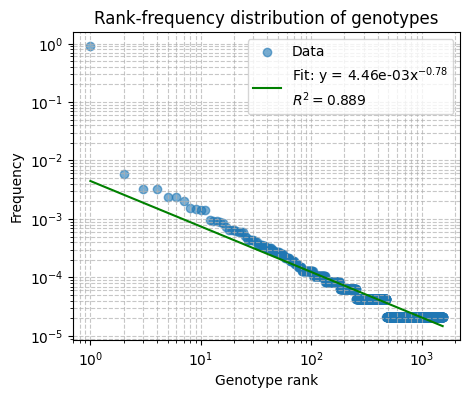

In [ ]:
n=sum([c for g,c in gen_list])
pj_hat=[c/n for g,c in gen_list]
a, b = _fit_linear_on_log_data(range(1,len(pj_hat)+1), pj_hat, show_plot=True)
plt.xlabel("Genotype rank")
plt.ylabel("Frequency")
plt.title("Rank-frequency distribution of genotypes")
plt.show()

In [ ]:
#| export

def find_power_law_breakpoint_KS(
    p_j_values: np.ndarray, 
    min_tail_size: int = 30,
    alpha_threshold: float = 0.5,
    verbose: bool = False
) -> tuple:
    """
    Finds the optimal breakpoint (start of the tail, j_min) for a power-law fit
    to a list of probability values (p_j), using a Kolmogorov-Smirnov (KS) based approach.

    The method iterates through possible j_min values, fits a power law to the
    tail (p_j for ranks >= j_min) via log-log linear regression, and then
    calculates the KS statistic between the CDF of the observed tail probabilities
    and the CDF of the fitted power-law probabilities (both normalized within the tail).
    The j_min that minimizes the KS statistic is chosen.

    Args:
        p_j_values (np.ndarray): A 1D NumPy array of probability estimates (p_j),
                                 sorted by rank (p_j for rank 1 is at index 0).
                                 Values should be positive.
        min_tail_size (int): The minimum number of data points required to form a tail
                             for fitting a power law. Default is 30.
        alpha_threshold (float): The minimum positive value for a fitted alpha
                                 to be considered a valid decaying power law.
                                 Default is 1e-2.
        verbose (bool): If True, prints progress and intermediate results.

    Returns:
        tuple: (best_j_min_rank, best_alpha, min_D_statistic)
               - best_j_min_rank: The rank (1-indexed) at which the power-law tail optimally begins.
               - best_alpha: The power-law exponent alpha fitted for the optimal tail.
               - min_D_statistic: The minimum KS statistic D achieved.
               Returns (None, None, np.inf) if no suitable tail is found.
    """
    N_obs = len(p_j_values)

    if N_obs < min_tail_size:
        if verbose:
            print(f"Number of observations ({N_obs}) is less than min_tail_size ({min_tail_size}). Cannot find breakpoint.")
        return None, None, np.inf

    # Ensure p_j_values are positive for log transformation
    if np.any(p_j_values <= 1e-12): # Use a small epsilon for comparison
        original_N_obs = N_obs
        positive_mask = p_j_values > 1e-12 
        p_j_values = p_j_values[positive_mask]
        N_obs = len(p_j_values)
        if verbose:
            print(f"Warning: p_j_values contained non-positive or very small values. Filtered {original_N_obs - N_obs} values.")
        if N_obs < min_tail_size:
            if verbose:
                print("Not enough positive p_j_values to find breakpoint after filtering.")
            return None, None, np.inf
    
    all_ranks = np.arange(1, N_obs + 1) # Ranks are 1-indexed

    min_D_statistic = np.inf
    best_j_min_rank = None 
    best_alpha = None

    for j_min_idx in range(1, N_obs - min_tail_size + 1):
        current_j_min_rank = all_ranks[j_min_idx] 
        
        tail_ranks = all_ranks[j_min_idx:]
        tail_p_j_observed = p_j_values[j_min_idx:]

        if len(tail_ranks) < 2: 
            continue

        log_tail_ranks = np.log(tail_ranks)
        log_tail_p_j_observed = np.log(tail_p_j_observed)

        try:
            slope, intercept, r_value, p_value, std_err = linregress(log_tail_ranks, log_tail_p_j_observed)
        except ValueError as e:
            if verbose:
                print(f"Skipping j_min_rank {current_j_min_rank}: Linregress failed ({e})")
            continue
            
        alpha_fit = -slope
        C_fit = np.exp(intercept)

        # MODIFIED: Check if alpha_fit indicates sufficient decay
        if alpha_fit <= alpha_threshold: 
            if verbose:
                print(f"Skipping j_min_rank {current_j_min_rank}: alpha_fit ({alpha_fit:.4f}) is <= threshold ({alpha_threshold})")
            continue

        p_j_fitted_tail = C_fit * (tail_ranks ** (-alpha_fit))
        
        if np.any(~np.isfinite(p_j_fitted_tail)) or np.any(p_j_fitted_tail < 0):
            if verbose:
                print(f"Skipping j_min_rank {current_j_min_rank}: Fitted probabilities are not valid.")
            continue

        sum_obs_tail = np.sum(tail_p_j_observed)
        sum_fit_tail = np.sum(p_j_fitted_tail)

        if sum_obs_tail <= 1e-9 or sum_fit_tail <= 1e-9: 
            if verbose:
                print(f"Skipping j_min_rank {current_j_min_rank}: Sum of probabilities in tail is too small for normalization.")
            continue
            
        norm_tail_p_j_observed = tail_p_j_observed / sum_obs_tail
        norm_p_j_fitted_tail = p_j_fitted_tail / sum_fit_tail
        
        cdf_observed_tail = np.cumsum(norm_tail_p_j_observed)
        cdf_fitted_tail = np.cumsum(norm_p_j_fitted_tail)
        D_statistic = np.max(np.abs(cdf_observed_tail - cdf_fitted_tail))

        if verbose:
            print(f"j_min_rank={current_j_min_rank}, alpha={alpha_fit:.3f}, D={D_statistic:.4f}, R^2={r_value**2:.3f}")

        if D_statistic < min_D_statistic:
            min_D_statistic = D_statistic
            best_j_min_rank = current_j_min_rank
            best_alpha = alpha_fit

    if best_j_min_rank is None and verbose:
        print("Could not find a suitable breakpoint meeting all criteria.")

    return best_j_min_rank, best_alpha, min_D_statistic

j_min_rank=2, alpha=0.755, D=0.1507, R^2=0.908
j_min_rank=3, alpha=0.751, D=0.1398, R^2=0.906
j_min_rank=4, alpha=0.749, D=0.1363, R^2=0.905
j_min_rank=5, alpha=0.745, D=0.1294, R^2=0.903
j_min_rank=6, alpha=0.743, D=0.1252, R^2=0.902
j_min_rank=7, alpha=0.739, D=0.1192, R^2=0.901
j_min_rank=8, alpha=0.736, D=0.1138, R^2=0.899
j_min_rank=9, alpha=0.734, D=0.1106, R^2=0.898
j_min_rank=10, alpha=0.731, D=0.1068, R^2=0.897
j_min_rank=11, alpha=0.729, D=0.1026, R^2=0.896
j_min_rank=12, alpha=0.726, D=0.0977, R^2=0.895
j_min_rank=13, alpha=0.724, D=0.0957, R^2=0.894
j_min_rank=14, alpha=0.722, D=0.0937, R^2=0.893
j_min_rank=15, alpha=0.720, D=0.0914, R^2=0.892
j_min_rank=16, alpha=0.717, D=0.0889, R^2=0.891
j_min_rank=17, alpha=0.715, D=0.0862, R^2=0.890
j_min_rank=18, alpha=0.713, D=0.0842, R^2=0.889
j_min_rank=19, alpha=0.711, D=0.0829, R^2=0.888
j_min_rank=20, alpha=0.710, D=0.0814, R^2=0.887
j_min_rank=21, alpha=0.708, D=0.0800, R^2=0.886
j_min_rank=22, alpha=0.706, D=0.0788, R^2=0.885


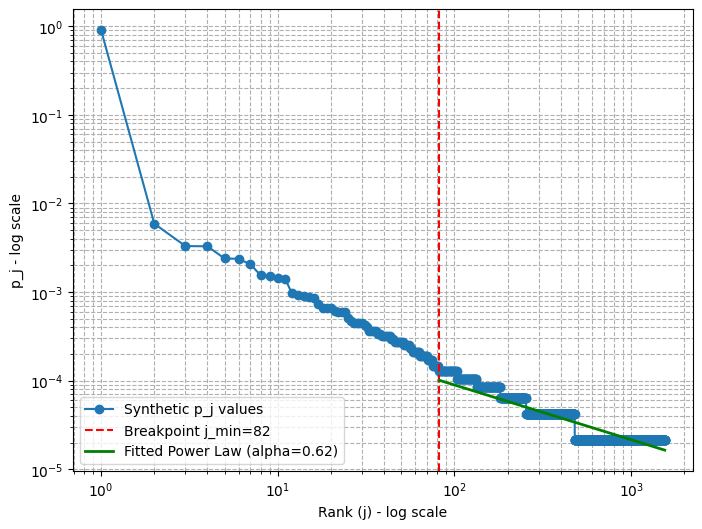

In [ ]:
ranks=np.arange(1,len(pj_hat)+1)
pj_hat=np.array(pj_hat)
best_j_min, best_alpha, min_D = find_power_law_breakpoint_KS(pj_hat, min_tail_size=20, alpha_threshold=0.5, verbose=True)
plt.figure(figsize=(8, 6))
plt.loglog(ranks, pj_hat, 'o-', label='Synthetic p_j values')
plt.xlabel('Rank (j) - log scale')
plt.ylabel('p_j - log scale')
plt.grid(True, which="both", ls="--")

print(f"\nOptimal breakpoint (j_min_rank): {best_j_min}")
print(f"Fitted alpha for the tail: {best_alpha:.3f}")
print(f"Minimum KS statistic (D): {min_D:.4f}")

# Add breakpoint to plot
plt.axvline(best_j_min, color='r', linestyle='--', label=f'Breakpoint j_min={best_j_min}')
log_ranks_tail = np.log(ranks[best_j_min-1:])

# Re-fit to the chosen tail to get intercept for plotting the line
if len(log_ranks_tail) >=2 :
    log_p_j_tail = np.log(pj_hat[best_j_min-1:])
    slope_final, intercept_final, _, _, _ = linregress(log_ranks_tail, log_p_j_tail)
    alpha_final = -slope_final
    C_final = np.exp(intercept_final)
    
    fitted_line = C_final * (ranks[best_j_min-1:]**(-alpha_final))
    plt.loglog(ranks[best_j_min-1:], fitted_line, 'g-', linewidth=2, label=f'Fitted Power Law (alpha={alpha_final:.2f})')
plt.legend()
plt.show()

In [ ]:
#| export
def find_power_law_breakpoint_R(
    p_j_values: np.ndarray, 
    min_tail_size: int = 10,
    alpha_threshold: float = 0.5, 
    r_squared_threshold: float = 0.80,
    verbose: bool = False
) -> tuple:
    """
    Finds the optimal breakpoint (start of the tail, j_min) for a power-law fit
    to a list of probability values (p_j). The primary selection criterion is
    maximizing the R-squared of the log-log linear regression for the tail.
    A minimum alpha_threshold for the decay and a minimum r_squared_threshold
    for the fit quality are applied.
    Also returns the probability mass in the identified head and tail.

    Args:
        p_j_values (np.ndarray): A 1D NumPy array of probability estimates (p_j),
                                 sorted by rank (p_j for rank 1 is at index 0).
        min_tail_size (int): The minimum number of data points required to form a tail
                             for fitting a power law. Default is 30.
        alpha_threshold (float): The minimum positive value for a fitted alpha
                                 to be considered a valid decaying power law.
                                 Default is 1e-2.
        r_squared_threshold (float): The minimum R-squared value from the log-log fit
                                     for a tail to be considered a candidate. Default is 0.80.
        verbose (bool): If True, prints progress and intermediate results.

    Returns:
        tuple: (best_j_min_rank, best_alpha, best_r_squared, head_mass, tail_mass)
               - best_j_min_rank: The rank (1-indexed) at which the power-law tail optimally begins
                                  (relative to the start of p_j_for_fitting).
               - best_alpha: The power-law exponent alpha fitted for the optimal tail.
               - best_r_squared: The maximum R-squared achieved by the best fit.
    """
    # Filter out non-positive p_j values as they are problematic for log transforms
    p_j_for_fitting = p_j_values[p_j_values > 1e-12] # Use a small epsilon
    N_obs_fitting = len(p_j_for_fitting)
    sum_all_valid_input_pj = np.sum(p_j_for_fitting)

    if N_obs_fitting < min_tail_size:
        if verbose:
            print(f"Not enough positive observations ({N_obs_fitting}) for fitting. Min tail size: {min_tail_size}.")
        return None, None, -np.inf
    
    # Ranks for the filtered data used in fitting (1-indexed)
    all_ranks_fitting = np.arange(1, N_obs_fitting + 1) 

    valid_fits = [] # List to store dictionaries of valid fit results

    # Iterate through possible start indices for the tail within the filtered data
    for j_min_idx_filtered in range(N_obs_fitting - min_tail_size + 1):
        current_j_min_rank_filtered = all_ranks_fitting[j_min_idx_filtered] 
        
        # Slice data for the current candidate tail
        tail_ranks_filtered = all_ranks_fitting[j_min_idx_filtered:]
        tail_p_j_observed_filtered = p_j_for_fitting[j_min_idx_filtered:]
        num_points_in_current_tail = len(tail_ranks_filtered)

        # Prepare data for log-log linear regression
        log_tail_ranks = np.log(tail_ranks_filtered)
        log_tail_p_j_observed = np.log(tail_p_j_observed_filtered)

        try:
            slope, intercept, r_value, p_value, std_err = linregress(log_tail_ranks, log_tail_p_j_observed)
        except ValueError as e: 
            if verbose:
                print(f"  Candidate j_min_rank_filt={current_j_min_rank_filtered}: Linregress failed ({e}). Skipping.")
            continue
            
        alpha_fit = -slope
        r_squared_fit = r_value**2
        
        # Apply quality thresholds for the fit
        if alpha_fit <= alpha_threshold: 
            if verbose:
                print(f"  Candidate j_min_rank_filt={current_j_min_rank_filtered}: alpha_fit ({alpha_fit:.4f}) is <= threshold ({alpha_threshold}). Skipping.")
            continue
        
        if r_squared_fit < r_squared_threshold:
            if verbose:
                print(f"  Candidate j_min_rank_filt={current_j_min_rank_filtered}: R^2 ({r_squared_fit:.4f}) is < threshold ({r_squared_threshold}). Skipping.")
            continue

        if verbose:
            print(f"  VALID Candidate: j_min_rank_filt={current_j_min_rank_filtered}, N_tail={num_points_in_current_tail}, alpha={alpha_fit:.3f}, R^2={r_squared_fit:.3f}")

        valid_fits.append({
            "num_points": num_points_in_current_tail,
            "j_min_rank": current_j_min_rank_filtered, # Rank within p_j_for_fitting
            "alpha": alpha_fit,
            "r_squared": r_squared_fit 
        })

    if not valid_fits:
        if verbose:
            print("No valid fits found meeting all criteria (alpha_threshold, r_squared_threshold).")
        return None, None, -np.inf

    # Sort valid fits: Primary by R-squared (desc), Secondary by num_points (desc)
    valid_fits.sort(key=lambda x: (x["r_squared"], x["num_points"]), reverse=True)

    best_fit = valid_fits[0]
    best_r_squared = best_fit["r_squared"]
    best_j_min_rank_in_filtered = best_fit["j_min_rank"]
    best_alpha = best_fit["alpha"]
    
    if verbose:
        print(f"\nSelected best fit after sorting: j_min_rank_filt={best_j_min_rank_in_filtered}, N_tail={best_fit['num_points']}, alpha={best_alpha:.3f}, R^2={best_r_squared:.3f}")
    
        
    return best_j_min_rank_in_filtered, best_alpha, best_r_squared

  VALID Candidate: j_min_rank_filt=1, N_tail=1550, alpha=0.778, R^2=0.889
  VALID Candidate: j_min_rank_filt=2, N_tail=1549, alpha=0.755, R^2=0.908
  VALID Candidate: j_min_rank_filt=3, N_tail=1548, alpha=0.751, R^2=0.906
  VALID Candidate: j_min_rank_filt=4, N_tail=1547, alpha=0.749, R^2=0.905
  VALID Candidate: j_min_rank_filt=5, N_tail=1546, alpha=0.745, R^2=0.903
  VALID Candidate: j_min_rank_filt=6, N_tail=1545, alpha=0.743, R^2=0.902
  VALID Candidate: j_min_rank_filt=7, N_tail=1544, alpha=0.739, R^2=0.901
  VALID Candidate: j_min_rank_filt=8, N_tail=1543, alpha=0.736, R^2=0.899
  VALID Candidate: j_min_rank_filt=9, N_tail=1542, alpha=0.734, R^2=0.898
  VALID Candidate: j_min_rank_filt=10, N_tail=1541, alpha=0.731, R^2=0.897
  VALID Candidate: j_min_rank_filt=11, N_tail=1540, alpha=0.729, R^2=0.896
  VALID Candidate: j_min_rank_filt=12, N_tail=1539, alpha=0.726, R^2=0.895
  VALID Candidate: j_min_rank_filt=13, N_tail=1538, alpha=0.724, R^2=0.894
  VALID Candidate: j_min_rank_filt

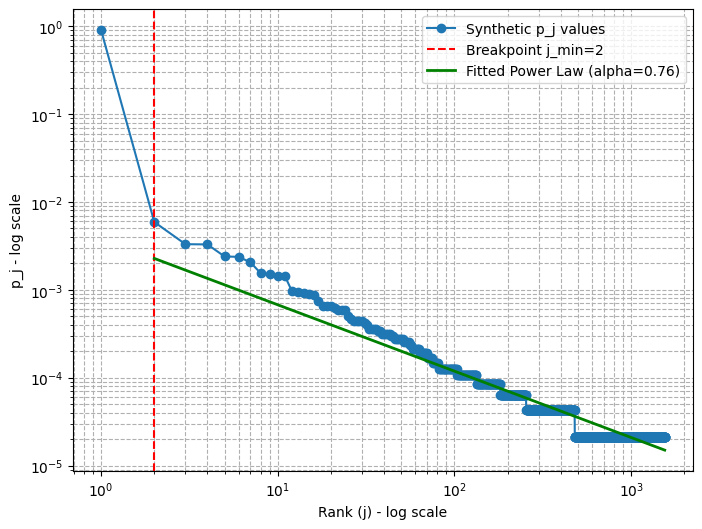

In [ ]:
ranks=np.arange(1,len(pj_hat)+1)
pj_hat=np.array(pj_hat)
best_j_min, best_alpha, best_r_squared = find_power_law_breakpoint_R(pj_hat,verbose=True)
plt.figure(figsize=(8, 6))
plt.loglog(ranks, pj_hat, 'o-', label='Synthetic p_j values')
plt.xlabel('Rank (j) - log scale')
plt.ylabel('p_j - log scale')
plt.grid(True, which="both", ls="--")

print(f"\nOptimal breakpoint (j_min_rank): {best_j_min}")
print(f"Fitted alpha for the tail: {best_alpha:.3f}")
print(f"Best R squared: {best_r_squared:.4f}")

# Add breakpoint to plot
plt.axvline(best_j_min, color='r', linestyle='--', label=f'Breakpoint j_min={best_j_min}')
log_ranks_tail = np.log(ranks[best_j_min-1:])

# Re-fit to the chosen tail to get intercept for plotting the line
if len(log_ranks_tail) >=2 :
    log_p_j_tail = np.log(pj_hat[best_j_min-1:])
    slope_final, intercept_final, _, _, _ = linregress(log_ranks_tail, log_p_j_tail)
    alpha_final = -slope_final
    C_final = np.exp(intercept_final)
    
    fitted_line = C_final * (ranks[best_j_min-1:]**(-alpha_final))
    plt.loglog(ranks[best_j_min-1:], fitted_line, 'g-', linewidth=2, label=f'Fitted Power Law (alpha={alpha_final:.2f})')
plt.legend()
plt.show()

In [ ]:
#| export
def _power_law_tail_prob_func(
    rank: float, 
    k_obs_head_size: int, 
    params: Dict[str, Any]
) -> float:
    """Calculate probability for power law tail distribution.
    
    Args:
        rank: Position in rank-ordered distribution
        k_obs_head_size: Number of observed variants in head distribution
        params: Dictionary containing 'C_norm' (normalization constant) and 
               'alpha_decay' (power law exponent)
    
    Returns:
        float: Probability value between 0 and 1
    """
    if rank <= k_obs_head_size: 
        return 0.0 
    
    C_norm = params.get('C_norm') 
    alpha_decay = params.get('alpha_decay')
    
    prob = C_norm * (rank ** (-alpha_decay))
    return max(0.0, min(prob, 1.0))

#| export
def _calculate_C_norm_for_power_law(
    P_tail_mass_target: float,
    alpha_decay: float, 
    integration_lower_bound: float,
    integration_upper_bound: float
) -> float:
    """Calculate normalization constant for power law distribution.
    
    Args:
        P_tail_mass_target: Target probability mass for tail distribution
        alpha_decay: Power law exponent
        integration_lower_bound: Lower bound for integration
        integration_upper_bound: Upper bound for integration (can be np.inf)
    
    Returns:
        float: Normalization constant C_norm
        
    Notes:
        - Handles special cases for alpha_decay ≈ 1.0
        - Includes numerical stability checks
        - Returns 0.0 for invalid/degenerate cases
    """
    if P_tail_mass_target <= 1e-9: 
        return 0.0
    
    if integration_lower_bound <= 1e-9:
        print(f"Warning: integration_lower_bound ({integration_lower_bound}) for C_norm calculation is <= 0. Adjusting to 1e-9.")
        integration_lower_bound = 1e-9

    L, U = integration_lower_bound, integration_upper_bound
    one_minus_alpha = 1.0 - alpha_decay

    # Special case for alpha ≈ 1
    if abs(alpha_decay - 1.0) < 1e-9:
        if U == np.inf:
            return 0.0
        return P_tail_mass_target / (np.log(U) - np.log(L)) if U > 0 and L > 0 else 0.0
    
    try:
        term_L = L ** one_minus_alpha
        if U == np.inf:
            if one_minus_alpha > 0:
                return 0.0
            I_shape = -term_L / one_minus_alpha
        else:
            term_U = U ** one_minus_alpha
            I_shape = (term_U - term_L) / one_minus_alpha
    except OverflowError:
        print(f"Warning: OverflowError in C_norm calculation")
        return 0.0

    if I_shape <= 1e-12:
        return 0.0 if P_tail_mass_target < 1e-9 else P_tail_mass_target / max(I_shape, 1e-12)
        
    return P_tail_mass_target / I_shape

In [ ]:
#| hide
alpha_decay = 1.5
P_tail_mass = 0.3
k_obs_head_size = 20
C_norm = _calculate_C_norm_for_power_law(P_tail_mass, alpha_decay, k_obs_head_size, 1e18)

my_tail_params = {'C_norm': C_norm, 'alpha_decay': alpha_decay}

#checking C_norm calculation
tail_mass = sum([_power_law_tail_prob_func(r, k_obs_head_size, params=my_tail_params) for r in range(k_obs_head_size,1000000)])
assert tail_mass<P_tail_mass and tail_mass>P_tail_mass-0.05, f"Tail mass {tail_mass} is not close to target {P_tail_mass}"

In [ ]:
#| export

def _term_contribution(p_j: float, n_target: int) -> float:
    """
    Calculates 1 - (1 - p_j)^n_target robustly.
    This is the probability that item j is seen at least once in n_target draws.
    """
    if not (0.0 <= p_j <= 1.0):
        raise ValueError(f"Probability p_j must be between 0 and 1, got {p_j}")
    if n_target < 0:
        raise ValueError(f"n_target must be non-negative, got {n_target}")
    if n_target == 0:
        return 0.0
    if p_j == 1.0:
        return 1.0
    if p_j == 0.0:
        return 0.0

    # Calculate (1 - p_j)^n_target using logarithms for stability with large n_target
    log_prob_not_seen_one_draw = np.log1p(-p_j) # More stable: log(1 + (-p_j))

    # Total log probability of not seeing the item in n_target draws
    total_log_prob_not_seen = n_target * log_prob_not_seen_one_draw

    # If total_log_prob_not_seen is very small (e.g., -709 makes exp underflow to 0)
    # then prob_not_seen is effectively 0.
    if total_log_prob_not_seen < -708: # Threshold for np.exp underflow
        prob_not_seen = 0.0
    else:
        prob_not_seen = np.exp(total_log_prob_not_seen)
        
    return 1.0 - prob_not_seen

def _integrand_for_tail(
    rank: float, 
    n_target: int, 
    k_obs_head_size: int,
    tail_prob_func: Callable[[float, int, Dict[str, Any]], float], 
    params_for_tail_func: Dict[str, Any]
) -> float:
    """
    Integrand function for the tail: 1 - (1 - p(rank))^n_target.
    'rank' is the continuous variable of integration.
    'tail_prob_func' provides p(rank).
    """
    pj = tail_prob_func(rank, k_obs_head_size, params_for_tail_func)
    return _term_contribution(pj, n_target)

def estimate_U_n_hybrid(
    observed_counts: List[int],
    n_target: int,
    k_obs_head_size: int,
    P_head_mass_allocation: float,
    tail_prob_func: Callable[[float, int, Dict[str, Any]], float],
    tail_params: Dict[str, Any],
    G_approx_upper_limit: float = 1e19
) -> float:
    """
    Estimates U(n_target), the expected number of unique items after n_target draws.

    Args:
        observed_counts: List of counts for the most frequent items, in decreasing order.
        n_target: The number of draws (n) for which to calculate U(n).
        P_head_mass_allocation: The total probability mass allocated to the items
                                 in observed_counts. (e.g., 0.9 if head covers 90% mass).
        tail_prob_func: User-provided function for tail probabilities:
                        `func(rank, k_obs_head_size, tail_params) -> p_j`
                        This function's parameters in `tail_params` (e.g., C_norm)
                        should be set such that the tail integrates to (1 - P_head_mass_allocation).
        tail_params: Parameters for the tail_prob_func.
        G_approx_upper_limit: Effective upper limit for tail integration.

    Returns:
        The estimated expected number of unique items, U(n_target).
    """
    # Initialize variables and validate inputs
    head_counts = sum(observed_counts[:k_obs_head_size])

    # Calculate head contribution
    u_head = 0.0
    if head_counts > 0 and P_head_mass_allocation > 0:
        for count in observed_counts[:k_obs_head_size]:
            if count <= 0:
                continue
            pj = (count / head_counts) * P_head_mass_allocation
            u_head += _term_contribution(pj, n_target)
    elif P_head_mass_allocation > 0 and head_counts == 0 and k_obs_head_size > 0:
        print("Warning: P_head_mass_allocation > 0 but no counts in observed_counts to distribute it to.")

    # Calculate tail contribution
    u_tail = 0.0
    tail_mass = 1.0 - P_head_mass_allocation
    lower_bound = float(k_obs_head_size)

    if tail_mass > 1e-9 and G_approx_upper_limit > (lower_bound + 1e-9):
        if not callable(tail_prob_func) or tail_params is None:
            print("Warning: tail_prob_func is not callable or tail_params not provided. U_tail set to 0.")
            return u_head

        # Calculate integration points for improved accuracy
        integration_points = []
        C_norm = tail_params.get('C_norm', 0)
        alpha_decay = tail_params.get('alpha_decay', 0)

        if n_target > 0 and C_norm > 1e-12 and alpha_decay > 1e-9:
            try:
                log_x_star = (np.log(n_target) + np.log(C_norm)) / alpha_decay
                if log_x_star < 709:  # Prevent exp overflow
                    x_star = np.exp(log_x_star)
                    for factor in [0.1, 1.0, 10.0]:
                        point = factor * x_star
                        if lower_bound < point < G_approx_upper_limit:
                            integration_points.append(point)
            except Exception:
                print("Info: Could not calculate characteristic point x_star for integration.")

        # Perform numerical integration
        try:
            integration_points = sorted(set(integration_points))
            u_tail, _ = quad(
                _integrand_for_tail,
                lower_bound,
                G_approx_upper_limit,
                args=(n_target, k_obs_head_size, tail_prob_func, tail_params),
                epsabs=1e-7,
                epsrel=1e-7,
                limit=1000,
                points=integration_points if integration_points else None
            )
        except Exception as e:
            print(f"Warning: Error during tail integration: {e}. U_tail set to 0.")
            u_tail = 0.0
    elif tail_mass <= 1e-9:
        print("Info: Tail probability mass is effectively zero, U_tail will be 0.")

    #print(f"U_head: {u_head}, U_tail: {u_tail}, Total U(n_target): {u_head + u_tail}")
    return u_head + u_tail

In [ ]:
#| hide
gen_dict = dict(gen_list)
n = sum(gen_dict.values())

G=4**20
#k_obs_head_size = 10
#P_head_mass_allocation = sum(list(gen_dict.values())[:k_obs_head_size])/n


#a, b = _fit_linear_on_log_data(range(1,len(pj_hat)+1), pj_hat, show_plot=True)

best_j_min, best_alpha, min_D = find_power_law_breakpoint_KS(pj_hat, min_tail_size=20, alpha_threshold=0.5, verbose=False)
k_obs_head_size = best_j_min
P_head_mass_allocation = sum(pj_hat[:best_j_min-1])/sum(pj_hat)

print(f"\nOptimal breakpoint (j_min_rank): {best_j_min}")
print(f"Fitted alpha for the tail: {best_alpha:.3f}")
print(f"P_head_mass_allocation: {P_head_mass_allocation:.4f}")

alpha_decay = best_alpha

calculated_C_norm = _calculate_C_norm_for_power_law(
    1-P_head_mass_allocation, # Use the user-defined P_tail for C_norm
    alpha_decay,
    k_obs_head_size, 
    G
)

print(f"Calculated C_norm for tail: {calculated_C_norm:.6e}")
my_tail_params = {'C_norm': calculated_C_norm, 'alpha_decay': alpha_decay}

n_target_draws = 10**9
print(f"\nCalculating U(n) for n_target = {n_target_draws:,.0e}")
print(f"k_obs (head size) = {k_obs_head_size}")
print(f"Effective G for tail integration upper limit: {G:.2e}")
print(f"Using Tail model parameters: {my_tail_params}")


u_n_estimated = estimate_U_n_hybrid(
    [c for g,c in gen_list],
    n_target_draws, # n_target_draws
    k_obs_head_size, # k_obs_head_size
    P_head_mass_allocation, # P_head_mass_allocation
    _power_law_tail_prob_func, 
    my_tail_params,
    G_approx_upper_limit=G
)
u_n_estimated


Optimal breakpoint (j_min_rank): 82
Fitted alpha for the tail: 0.618
P_head_mass_allocation: 0.9531
Calculated C_norm for tail: 4.470673e-07

Calculating U(n) for n_target = 1e+09
k_obs (head size) = 82
Effective G for tail integration upper limit: 1.10e+12
Using Tail model parameters: {'C_norm': np.float64(4.470673415960114e-07), 'alpha_decay': np.float64(0.6176677216091059)}


46880873.962438986

In [ ]:
#| export
def estimate_library_size(
    observed_counts: list,
    n_target: int,
    G: float = 1e19,
    verbose: bool = False,
) -> float:
    """
    Estimate the library size (U(n_target)) based on observed counts and target draws.

    Args:
        observed_counts: List of observed counts for the most frequent items.
        n_target: The number of draws (n) for which to calculate U(n).
        G: Effective upper limit for tail integration.
        verbose: If True, prints progress information.

    Returns:
        Estimated library size U(n_target).
    """
    pj_hat = np.array(observed_counts) / sum(observed_counts)
    
    best_j_min, best_alpha, best_r_squared = find_power_law_breakpoint_R(pj_hat, min_tail_size=10, alpha_threshold=0.5, verbose=verbose)

    if not best_j_min:
        print("Not enough data to estimate library size.")
        return None
    P_head_mass_allocation = sum(pj_hat[:best_j_min-1])/sum(pj_hat)
    alpha_decay = best_alpha
    k_obs_head_size=best_j_min

    if verbose:
        print(f"\nOptimal breakpoint (j_min_rank): {best_j_min}")
        print(f"Fitted alpha for the tail: {best_alpha:.3f}")
        print(f"P_head_mass_allocation: {P_head_mass_allocation:.4f}")
        plt.figure(figsize=(8, 6))
        ranks = np.arange(1, len(pj_hat) + 1)
        plt.loglog(ranks, pj_hat, 'o-')
        plt.xlabel('Rank (j) - log scale')
        plt.ylabel('p_j - log scale')
        plt.grid(True, which="both", ls="--")

        # Add breakpoint to plot
        plt.axvline(best_j_min, color='r', linestyle='--', label=f'Breakpoint j_min={best_j_min}')
        log_ranks_tail = np.log(ranks[best_j_min-1:])

        # Re-fit to the chosen tail to get intercept for plotting the line
        if len(log_ranks_tail) >=2 :
            log_p_j_tail = np.log(pj_hat[best_j_min-1:])
            slope_final, intercept_final, _, _, _ = linregress(log_ranks_tail, log_p_j_tail)
            alpha_final = -slope_final
            C_final = np.exp(intercept_final)
            
            fitted_line = C_final * (ranks[best_j_min-1:]**(-alpha_final))
            plt.loglog(ranks[best_j_min-1:], fitted_line, 'g-', linewidth=2, label=f'Fitted Power Law (alpha={alpha_final:.2f})')
        plt.legend()
        plt.show()

    
    calculated_C_norm = _calculate_C_norm_for_power_law(
        1-P_head_mass_allocation,
        alpha_decay,
        best_j_min, 
        G
    )

    if verbose:
        print(f"Calculated C_norm for tail: {calculated_C_norm:.6e}")
        print(f"\nCalculating U(n) for n_target = {n_target:,.0e}")
        print(f"k_obs (head size) = {k_obs_head_size}")
        print(f"Effective G for tail integration upper limit: {G:.2e}")
    
    my_tail_params = {'C_norm': calculated_C_norm, 'alpha_decay': alpha_decay}
    if verbose:
        print(f"Using Tail model parameters: {my_tail_params}")

    return estimate_U_n_hybrid(
        observed_counts,
        n_target,
        k_obs_head_size,
        P_head_mass_allocation,
        _power_law_tail_prob_func,
        my_tail_params,
        G_approx_upper_limit=G
    )

In [ ]:
estimate_library_size([c for g,c in gen_list], 10**9, 4**16)

79557123.89369781

  VALID Candidate: j_min_rank_filt=1, N_tail=1550, alpha=0.778, R^2=0.889
  VALID Candidate: j_min_rank_filt=2, N_tail=1549, alpha=0.755, R^2=0.908
  VALID Candidate: j_min_rank_filt=3, N_tail=1548, alpha=0.751, R^2=0.906
  VALID Candidate: j_min_rank_filt=4, N_tail=1547, alpha=0.749, R^2=0.905
  VALID Candidate: j_min_rank_filt=5, N_tail=1546, alpha=0.745, R^2=0.903
  VALID Candidate: j_min_rank_filt=6, N_tail=1545, alpha=0.743, R^2=0.902
  VALID Candidate: j_min_rank_filt=7, N_tail=1544, alpha=0.739, R^2=0.901
  VALID Candidate: j_min_rank_filt=8, N_tail=1543, alpha=0.736, R^2=0.899
  VALID Candidate: j_min_rank_filt=9, N_tail=1542, alpha=0.734, R^2=0.898
  VALID Candidate: j_min_rank_filt=10, N_tail=1541, alpha=0.731, R^2=0.897
  VALID Candidate: j_min_rank_filt=11, N_tail=1540, alpha=0.729, R^2=0.896
  VALID Candidate: j_min_rank_filt=12, N_tail=1539, alpha=0.726, R^2=0.895
  VALID Candidate: j_min_rank_filt=13, N_tail=1538, alpha=0.724, R^2=0.894
  VALID Candidate: j_min_rank_filt

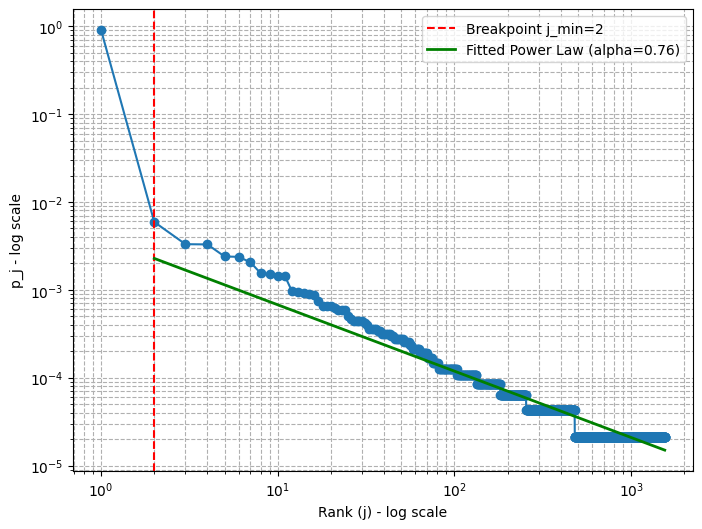

Calculated C_norm for tail: 1.045611e-04

Calculating U(n) for n_target = 1e+09
k_obs (head size) = 2
Effective G for tail integration upper limit: 4.29e+09
Using Tail model parameters: {'C_norm': np.float64(0.00010456107907340955), 'alpha_decay': np.float64(0.7550079517008023)}


79557123.89369781

In [ ]:
estimate_library_size([c for g,c in gen_list], 10**9, 4**16, verbose=True)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()